# Hamiltonian Monte Carlo
This script provides a basic implementation of the Hamiltonian Monte Carlo algorithm with Metropolis Hastings adjustment. A simple 1-dimensional Gaussian Mixture Model is employed as test distribution to sample from.

## Import some necessary packages

In [1]:
import numpy as np

from model.gmm import GaussianMixtureModel1D
from util.util import trace, plot_distribution

## Implementation of the actual algorithm
### The Hamiltonian differential equations
For a state variable $x$ and a virtual speed $v$, the Hamiltonian equations are definde as 
$$
\begin{align*}
H(x, v) &= U(x) + K(v) \\
\frac{d x}{d t} &= \frac{\partial H}{\partial v} = \frac{\partial K}{\partial v}= M^{-1}v\\
\frac{d v}{d t} &= -\frac{\partial H}{\partial x} = -\frac{\partial U}{\partial x}
\end{align*}
$$
with $M$ a positive definite weight matrix. With $M=I$, we choose 
$$
\begin{align*}
U(x) &= -\log (p(x)) \\
K(v) &= 0.5v^Tv \\
\end{align*}
$$

### Leapfrog
The proposal step in Hamiltonian Monte Carlo requires solving above differential equations. For this, we use the leapfrog algorithm.
$$
\begin{align*}
v(t+\frac{\epsilon}{2}) &= v(t) - \frac{\epsilon}{2}\frac{\partial U}{\partial z}(z(t)) \\
z(t+\epsilon) &= z(t) + \epsilon \frac{z(t+\frac{\epsilon}{2})}{m} \\
v(t+\epsilon) &= v(t+\frac{\epsilon}{2}) - \frac{\epsilon}{2}\frac{\partial U}{\partial z}(z(t+\epsilon))
\end{align*}
$$
The algorithm then hops around in the probability landscape for $L$ steps before it reaches its new state proposal.

### Acceptance probability 
As usual with Metropolis Hastings, an acceptance probability $\alpha$ needs to be computed, which then biases a coin-flip to decide if the proposal should be kept or discarded.
In HMC, $\alpha$ is computed as 
$$\alpha = \min \left(1, \exp(U - \tilde{U} + K - \tilde{K}) \right)$$
where $U, K$ denote the current and $\tilde{U}, \tilde{K}$ the proposed state and speed, respectively.

Below implementation is a direct transcription of the pseudocode presented in [1].

In [2]:
class HamiltonianMonteCarlo:
    def __init__(self, model, sigma=1.0, L=10, epsilon=0.1):
        self.model = model
        # Set U = -log(p(x))
        self.U = lambda x: -np.log(model(x))
        # Use the product rule to obtain grad(U)
        # grad(U) = -1 / p(x) * grad(p(x)) 
        self.grad_U = lambda x: -1 / model(x) * model.gradient(x)
        self.sigma = sigma
        self.L = L
        self.epsilon = epsilon

    def hmc_step(self, current_x):
        x = current_x
        v = np.random.normal(0, self.sigma)
        current_v = v

        # Leapfrog: half step for momentum
        v = v - self.epsilon * self.grad_U(x) / 2

        for i in range(self.L):
            # Leapfrog: full step for position
            x = x + self.epsilon * v

            # Leapfrog: combine 2 half-steps for momentum across iterations
            if (i != self.L-1):
                v = v - self.epsilon * self.grad_U(x)

        # Leapfrog: final half step for momentum
        v = v - self.epsilon * self.grad_U(x) / 2

        # Negate trajectory to make proposal symmetric
        v = -v

        # Compute potential and kinetic energies
        current_U = self.U(current_x)
        current_K = np.sum(current_v**2) / 2
        proposed_U = self.U(x)
        proposed_K = np.sum(v**2) / 2

        # Compute the acceptance probability and flip a coin accordingly:
        alpha = np.exp(current_U - proposed_U + current_K - proposed_K)
        alpha = min(1.0, alpha)
        if np.random.binomial(1, alpha, 1):
            return x
        else:
            return current_x

    def sample(self, num_samples):
        samples = []
        current_x = np.random.uniform(-2, 2)
        current_prob = self.model(current_x)

        while(len(samples) < num_samples):
            current_x = self.hmc_step(current_x)
            samples.append(current_x)

        return np.stack(samples)

## Run algorithm on some test distribution
We employ a simple 1-dimensional Gaussian-Mixture-Model as test distribution. We then instantiate the HMC algorithm and sample from the GMM.

In [3]:
model = GaussianMixtureModel1D(means=[-0.9, 0.7], sigmas=[0.2, 0.6])
hmc = HamiltonianMonteCarlo(model, L=10, epsilon=0.1)

samples = hmc.sample(num_samples=1000)

## Visualize results
Let's visualize the results. The function "trace" plots a complete trace of all samples over time alongside the target and estimated distribution on the left side. Additionally, the KL divergence is plottet over time to give a feeling for the algorithm's convergence behaviour.

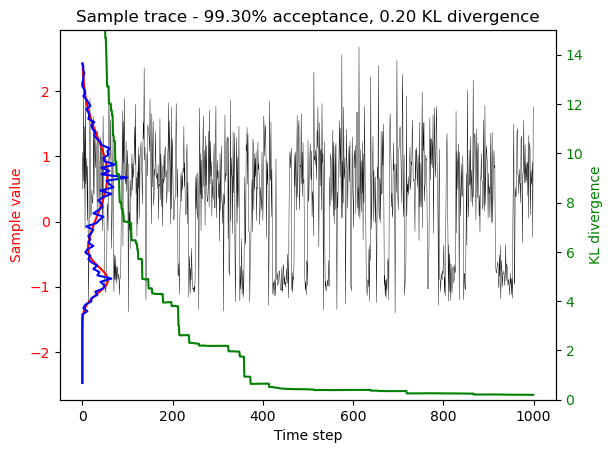

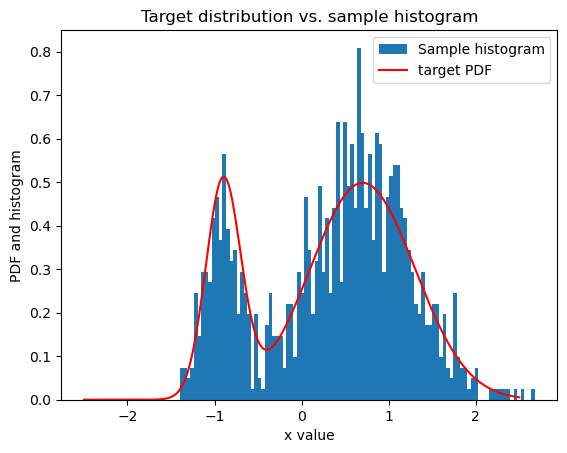

In [4]:
trace(model, samples)
plot_distribution(model, samples)

[1] Neal, Radford M. "MCMC using Hamiltonian dynamics." Handbook of markov chain monte carlo 2.11 (2011): 2.